A. Here are 400 random bits: 0000001101100100101000101100100110100000101001100100111101010000011111110100110101101000010111000100110111101101000110001101011011011000011010101100101111100011110010011110011011111010111000110110000100010111010110001111100011100111011101101111001110111110100101100010100100011110100010011110000111110011010101010000100001110101000101110110001001011011011111100111111110110101000000111111111110010100

1) Turn them into 200 random moves in the SmallGridWorld pictured below, in which there are two terminal states in gray and every move has reward -1: up=00, down=11, left=10, right=01.
2) Turn the 200 moves into episodes, each starting in state 5, the last episode possibly not terminating.
3) Starting with all state values equal to -18, apply first-visit Monte Carlo and Temporal Difference TD(0) with alpha = 0.1.
4) Visualize the updated state values after each episode.
5) Plot the root-mean squared error vs. episode number: $$RMS = \sqrt{\frac{1}{14} \sum_s \left( V(s) - v_\pi(s) \right)^2 }$$ where pi is the random policy.

![td.png](td.png)

In [8]:
# turning the action string into 200 action moves

action_string = "0000001101100100101000101100100110100000101001100100111101010000011111110100110101101000010111000100110111101101000110001101011011011000011010101100101111100011110010011110011011111010111000110110000100010111010110001111100011100111011101101111001110111110100101100010100100011110100010011110000111110011010101010000100001110101000101110110001001011011011111100111111110110101000000111111111110010100"

actions = [action_string[i:i+2] for i in range(0, len(action_string), 2)]
print(actions)

['00', '00', '00', '11', '01', '10', '01', '00', '10', '10', '00', '10', '11', '00', '10', '01', '10', '10', '00', '00', '10', '10', '01', '10', '01', '00', '11', '11', '01', '01', '00', '00', '01', '11', '11', '11', '01', '00', '11', '01', '01', '10', '10', '00', '01', '01', '11', '00', '01', '00', '11', '01', '11', '10', '11', '01', '00', '01', '10', '00', '11', '01', '01', '10', '11', '01', '10', '00', '01', '10', '10', '10', '11', '00', '10', '11', '11', '10', '00', '11', '11', '00', '10', '01', '11', '10', '01', '10', '11', '11', '10', '10', '11', '10', '00', '11', '01', '10', '00', '01', '00', '01', '01', '11', '01', '01', '10', '00', '11', '11', '10', '00', '11', '10', '01', '11', '01', '11', '01', '10', '11', '11', '00', '11', '10', '11', '11', '10', '10', '01', '01', '10', '00', '10', '10', '01', '00', '01', '11', '10', '10', '00', '10', '01', '11', '10', '00', '01', '11', '11', '00', '11', '01', '01', '01', '01', '00', '00', '10', '00', '01', '11', '01', '01', '00', '01', '01

In [9]:
import numpy as np
alpha = 0.1
reward = -1
# up=00, down=11, left=10, right=01
actions = ["00", "11", "10", "01"]


In [5]:
# v_s is the true state values according to the book
v_s = {
    1: -14,
    2: -20,
    3: -22,
    4: -14,
    5: -18,
    6: -20,
    7: -20,
    8: -22,
    9: -20,
    10: -14,
    11: -18,
    12: -22,
    13: -20,
    14: -14
}
def calculate_rms(V_s, v_s=v_s):
    return np.sqrt((1/14) * sum((V_s[s] - v_s[s])**2 for s in np.arange(1, 15)))

## First-Visit Monte Carlo

In [22]:
import numpy as np
# environment parameters
num_states = 16
terminal_states = [0, 15]
mc_state_values = np.full(num_states, -18, dtype=float)
returns = [[] for _ in range(num_states)]
epsilon = 0.1
actions_map = {"00": "up", "11": "down", "10": "left", "01": "right"}

'''
Here i implemented first-visit monte carlo for the gridworld presented.
i set the parameters according to the homework and the environment
created next_state function to tell the computer what state we will end up in after an action
generate_random_episode function creates episodes based on random action sequences
lastly, the loop runs the first-visit monte carlo algorithm from the book with random policy.
'''

def next_state(state, action):
  # 4x4 grid: states 0 (terminal), 1-14, 15 (terminal)
  if state in terminal_states:
    return state
  row, col = divmod(state, 4)
  if action == "00":  # up
    return state if row == 0 else (row - 1) * 4 + col

  if action == "11":  # down
    return state if row == 3 else (row + 1) * 4 + col

  if action == "10":  # left
    return state if col == 0 else state - 1

  if action == "01":  # right
    return state if col == 3 else state + 1

  return state

# generate an episode that chooses random actions until terminal state is reached
def generate_random_episode(actions, start_state=5):
    episode = []
    state = start_state
    for action in actions: # the random actions list is passed as an argument
      episode.append((state, action, -1))
      state = next_state(state, action)
      if state in terminal_states:
        break
    return episode

mc_rms = np.zeros(160)
gamma = 1.0
# run many episodes and only update the state value if it hasnt been visited yet
for n in range(160):  # number of episodes
  # take random actions
  episode_actions = np.random.choice(list(actions_map.keys()), 160)
  episode = generate_random_episode(episode_actions)
  visited = set()
  # updated my approach to calculating G - instead of reversing (which didn't work with first-visit), I am slicing from t to end to get accumalated G
  # i also failed to calculate G correctly because i wasn't using gamma or k variable but just the rewatd 
  # thus, i wasn't actually getting the sum of discounted rewards. i was just getting rewards.
  for t , (state, action, _) in enumerate(episode):
    if (state, action) in visited:
      continue  # skip if already visited
    visited.add((state, action)) # make sure to mark as visited
    G = 0
    for k, (_, _, reward) in enumerate(episode[t:]): # don't need state, and action here
      G += (gamma ** k) * reward # accumalted G from time step onwards

    returns[state].append(G) # add the return to the list of returns for that state
    mc_state_values[state] = np.mean(returns[state]) # update the state value with the average return
  mc_rms[n] = calculate_rms(mc_state_values)
      

# print visited states so we can check that the first-visit mc was implemented correctly
visited_states = [i for i, r in enumerate(returns) if len(r) > 0]
print("Visited states:", visited_states)
# check if mc state values are reasonable
print(mc_state_values)


Visited states: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[-18.          -9.96319018 -14.74820144 -17.03225806 -10.92258065
 -16.13945578 -15.26219512 -16.48214286 -15.95714286 -16.13095238
 -13.712      -12.56818182 -18.87341772 -16.8875     -10.34848485
 -18.        ]


## Temporal Difference TD(0)

V(s) ← V(s) +α[r+γV(s′)−V(s)]

In [19]:
num_episodes = 160 # closer to the episodes used in MC (10 episodes (200 actions / chunk size of 20) per start state (16 in total))
alpha = 0.1
gamma = 1.0 # undiscounted
td_state_values = np.full(num_states, -18, dtype=float)
starting_state = 5

td_rms = np.zeros(num_episodes)

# td(0) with random actions is implemented
def td_zero(num_episodes, alpha, gamma):
    for n in range(num_episodes):
        state = starting_state
        while state not in terminal_states:
            action = np.random.choice(list(actions_map.keys())) # choose random action
            # get next state based on random action
            next_s = next_state(state, action)
            reward = -1

            # TD(0) update (use td_state_values for both current and next state)
            td_state_values[state] += alpha * (
                reward + gamma * td_state_values[next_s] - td_state_values[state]
            )

            state = next_s
        td_rms[n] = calculate_rms(td_state_values)

td_zero(num_episodes, alpha, gamma)
print(td_state_values)

[-18.         -27.60434063 -31.84975043 -33.20485829 -27.81479301
 -31.06968279 -32.56288718 -32.05674385 -31.42033754 -31.83479763
 -30.59446839 -26.09563578 -31.68000915 -31.18241816 -27.73857572
 -18.        ]


In [10]:
import matplotlib.pyplot as plt

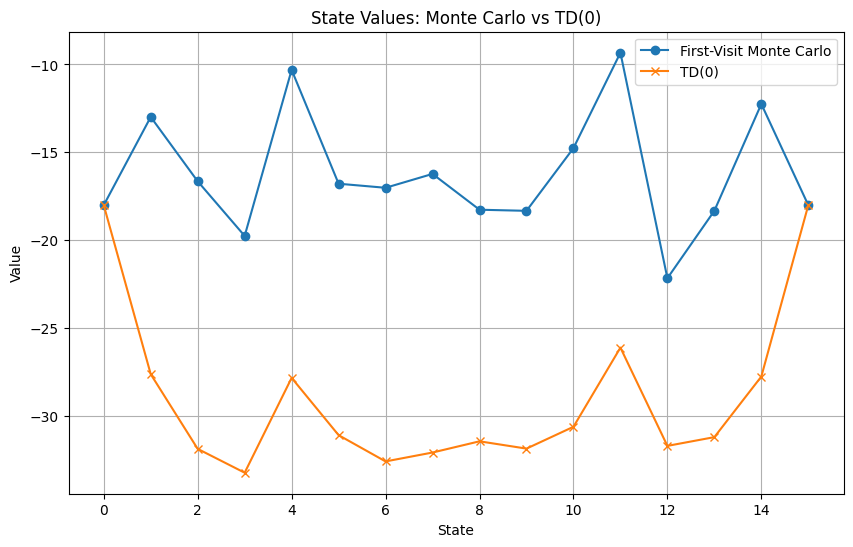

In [20]:
# Plot MC and TD(0) state values on the same graph
plt.figure(figsize=(10, 6))
plt.plot(mc_state_values, marker='o', label='First-Visit Monte Carlo')
plt.plot(td_state_values, marker='x', label='TD(0)')
plt.xlabel('State')
plt.ylabel('Value')
plt.title('State Values: Monte Carlo vs TD(0)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the Root Mean Squared Error RMS

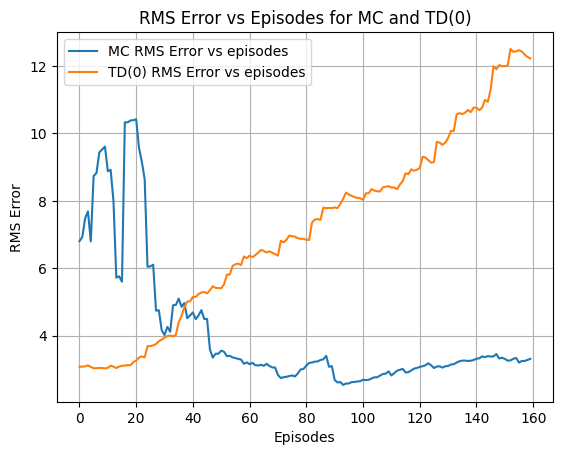

In [21]:
plt.plot(np.arange(160), mc_rms, label='MC RMS Error vs episodes')
plt.plot(np.arange(160), td_rms, label='TD(0) RMS Error vs episodes')
plt.xlabel('Episodes')
plt.ylabel('RMS Error')
plt.title('RMS Error vs Episodes for MC and TD(0)')
plt.legend()
plt.grid(True)
plt.show()